<font size='10'><h1 align="center"><font color='blue'>iPy oxDNA Examples</font></h1>

<center>
<img src="oxDNA.png">
</center>

<font size='10'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Duplex Melting</font></h2> 

In [1]:
from umbrella_sampling import ComUmbrellaSampling, MeltingUmbrellaSampling
from oxdna_simulation import SimulationManager, Simulation, Observable
from wham_analysis import collect_coms
import os
import matplotlib.pyplot as plt
from vmmc import *
from collections import Counter
from parameter_search import * 
import numpy as np
from skopt import Optimizer
from skopt.space import Categorical, Space
from scipy.special import logsumexp
from copy import deepcopy
from numba import jit
plt.style.use(['science', 'no-latex', 'bright'])
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [53]:
path = os.path.abspath('/scratch/matthew/ipy_oxDNA/ipy_oxdna_examples/ico_3p/')

system_name = 'inital_umbrella'

conditions = ['k05_xmax70_nwin100_45C']

systems = [f'{condition}' for condition in conditions]

file_dirs = [f'{path}/{system_name}' for _ in range(len(systems))]


monomer_1_patch_1 = '11674,11666,11667,11668,11669,11670,11671,11672,11673'
monomer_1_patch_2 = '12945,12953,12946,12947,12948,12949,12950,12951,12952'
monomer_1_patch_3 = '13320,13328,13321,13322,13323,13324,13325,13326,13327'

monomer_2_patch_1 = '6655,6663,6656,6657,6658,6659,6660,6661,6662'
monomer_2_patch_2 = '6358,6350,6351,6352,6353,6354,6355,6356,6357'
monomer_2_patch_3 = '5752,5744,5745,5746,5747,5748,5749,5750,5751'

monomer_1 = f'{monomer_1_patch_1},{monomer_1_patch_2},{monomer_1_patch_3}'
monomer_2 = f'{monomer_2_patch_1},{monomer_2_patch_2},{monomer_2_patch_3}'


xmin = 0
xmax = 70
n_windows = 100
starting_r0 = 1
stiff = 0.5
print_every = 1e4
temperature = '45C'
name = 'all_observables.txt'

pre_eq_steps = 1e7
eq_steps = 1e7
prod_steps = 2e8

verlet_skin = 0.5


pre_equlibration_parameters_list = [{'steps':f'{pre_eq_steps}','print_energy_every': f'{pre_eq_steps}',
                           'print_conf_interval':f'{pre_eq_steps}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}' }
                            for _ in conditions]

equlibration_parameters_list = [{'steps':f'{eq_steps}','print_energy_every': f'{eq_steps}',
                           'print_conf_interval':f'{eq_steps}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}'}
                            for _ in conditions]

production_parameters_list = [{'steps':f'{prod_steps}','print_energy_every': f'{prod_steps}',
                           'print_conf_interval':f'{prod_steps}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}'}
                            for _ in conditions]

us_list = [MeltingUmbrellaSampling(file_dir, sys, clean_build='force') for file_dir, sys in zip(file_dirs,systems)]

simulation_manager = SimulationManager()

In [ ]:
for us, pre_equlibration_parameters in zip(us_list, pre_equlibration_parameters_list):
    print(us.system)
    us.build_pre_equlibration_runs(simulation_manager, n_windows, monomer_1, monomer_2,
                               stiff, xmin, xmax, pre_equlibration_parameters, starting_r0, pre_eq_steps,
                               print_every=print_every, observable=True, protein=None,
                               force_file=None, continue_run=False, name=name)

In [ ]:
simulation_manager.worker_manager(gpu_mem_block=False)

In [ ]:
for us, equlibration_parameters in zip(us_list, equlibration_parameters_list):
    print(us.system)
    us.build_equlibration_runs(simulation_manager, n_windows, monomer_1, monomer_2,
                               stiff, xmin, xmax, equlibration_parameters, print_every=print_every,
                               observable=True, protein=None, force_file=None, continue_run=False, name=name)

In [ ]:
simulation_manager.worker_manager(gpu_mem_block=False)

In [ ]:
for us, production_parameters in zip(us_list, production_parameters_list):
    print(us.system)
    us.build_production_runs(simulation_manager, n_windows, monomer_1, monomer_2,
                             stiff, xmin, xmax, production_parameters,
                             observable=True, print_every=print_every ,protein=None,
                             force_file=None, continue_run=False, name=name)

In [ ]:
simulation_manager.run(gpu_mem_block=False)

In [ ]:
for us in us_list:
    us.observables_list = []
    us.com_distance_observable(monomer_1, monomer_2, print_every=print_every, name=name)
    us.hb_list_observable(print_every=print_every, only_count='true', name=name)
    us.force_energy_observable(print_every=print_every, name=name)
    us.potential_energy_observable(print_every=print_every, name=name)

wham_dir = os.path.abspath('/scratch/matthew/ipy_oxDNA/src/wham/wham')
n_bins = '400'
tol = '1e-12'
n_boot = '0'

monomer_1 = f'{monomer_1_patch_1},{monomer_1_patch_2},{monomer_1_patch_3}'
monomer_2 = f'{monomer_2_patch_1},{monomer_2_patch_2},{monomer_2_patch_3}'


xmin = 0
xmax = 60
n_windows = 100
starting_r0 = 1
steps = 1e6
stiff = 0.5
print_every = 2e4
temperature = '45C'
name = 'all_observables.txt'
for us in us_list:
    us.wham_run(wham_dir, xmin, xmax, stiff, n_bins, tol, n_boot, all_observables=True)
    
n_chunks = 2
data_added_per_iteration = 3

for us in us_list:
    us.wham.get_n_data_per_com_file()
    us.convergence_analysis(n_chunks, data_added_per_iteration, wham_dir, xmin, xmax, stiff, n_bins, tol, n_boot)

In [ ]:
for us in us_list:
    us.wham.plot_truncated_free_energy()
    plt.legend()
    plt.title(us.system)
    us.wham.plot_chunks_free_energy()
    plt.legend()
    plt.title(us.system)

In [ ]:
temp_range = np.arange(30, 80, 20)
n_bins = 200
xmin = 0
xmax = 60
max_hb = 8


free, F_i_temps, f_i_temps_over_time = us.wham_temperature_interpolation(temp_range, n_bins, xmin, xmax, epsilon=1e-5, reread_files=False)

us_list[0].temperature_interpolation(max_hb, temp_range, reread_files=False)

In [ ]:
calculated_bin_centers, bin_edges = us_list[0].get_bins(xmin, xmax, n_bins=200)
with plt.style.context(['science', 'no-latex', 'bright']): 

    fig, ax = plt.subplots(dpi=300)

    for f, temp_val in zip(free, temp_range):
        plt.plot(calculated_bin_centers*0.8518, f - f[5], label=f'{temp_val:.1f}C') 
        
    plt.legend(fontsize=6)

In [ ]:
for us in us_list:
    for idx in range(3, 8):
        us.analysis.view_conf('prod', idx)

In [54]:
for us in us_list:
    us.observables_list = []
    us.com_distance_observable(monomer_1, monomer_2, print_every=print_every, name=name)
    us.hb_list_observable(print_every=print_every, only_count='true', name=name)
    us.force_energy_observable(print_every=print_every, name=name)
    us.kinetic_energy_observable(print_every=print_every, name=name)
    us.potential_energy_observable(print_every=print_every, name=name)

all_observables = []
for us in us_list:
    all_observables.append(us.analysis.read_all_observables('prod'))

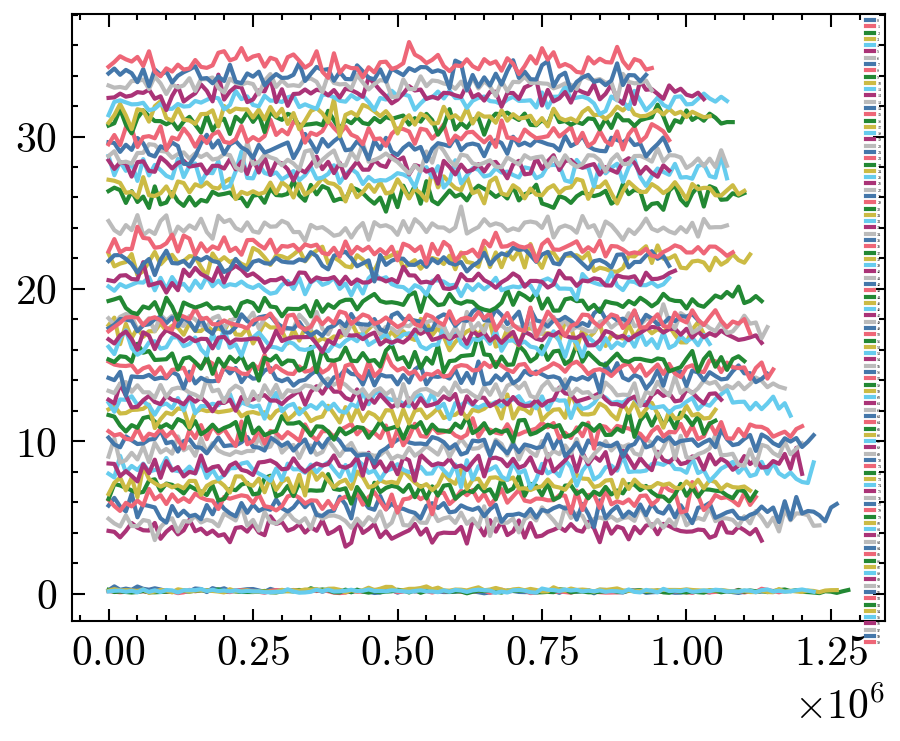

In [55]:
names = ['backbone', 'bonded_excluded_volume', 'stacking', 'nonbonded_excluded_volume', 'hydrogen_bonding', 'cross_stacking', 'coaxial_stacking', 'debye_huckel']
columns = ['com_distance', 'hb_list', 'force_energy', *names]

my_obs = all_observables[0]

fig, ax = plt.subplots(dpi=300)
for idx, obs in enumerate(my_obs):
    plt.plot(obs['steps'], obs['com_distance'], label=f'{idx}')
plt.legend(fontsize=1)

In [ ]:
sim = us.pre_equlibration_sims[0]
sim

In [ ]:
sim.oxpy_run.cms_obs((monomer_1_patch_1, monomer_2_patch_1), name='com_distance.txt', print_every=int(print_every))
sim.build(clean_build='force')
sim.oxpy_run.run()

In [ ]:
sim.oxpy_run.process.terminate()

In [ ]:
A = 0.34
B = 2
cupy_array = np.random.random((2, 100, 3))
cupy_array = A + (B-A) * cupy_array

In [ ]:
A = 0
B = 2.4
# cupy_array = np.random.random((2, 9, 3))
# cupy_array = A + (B-A) * cupy_array
new_pos = np.full((1), 1.5)
# new_pos = np.full((1, 9, 3), 1.5)

# pos = np.zeros((cupy_array.shape[1], cupy_array.shape[2]), dtype=np.float64)
# np.subtract(cupy_array[0], cupy_array[1], out=pos, dtype=np.float64)
# new_pos = np.linalg.norm(pos, axis=1)
r0 = np.full(new_pos.shape, 1.2*1.5)
gamma = 58.7
denominator = 1 + np.exp((new_pos - r0)*gamma)
term = 1 / denominator
final = np.sum(term) / np.float64(cupy_array.shape[1])
print(final)
print(new_pos)

def op(new_pos, gamma, r0, shape):
    return np.sum(1 / (1 + np.exp((new_pos - r0*shape)*gamma))) / np.float64(new_pos.shape[0])

In [ ]:
def op(new_pos, gamma, r0, shape):
    return np.sum(1 / (1 + np.exp((new_pos - r0*shape)*gamma))) / np.float64(new_pos.shape[0])

r0 = 1.2
shape = 1.5
gamma = 58.7

x_vals = np.linspace(0, 2.4, 100)
y_vals = [op(np.array([x_val]), gamma, r0, shape) for x_val in x_vals]


plt.plot(x_vals, y_vals)

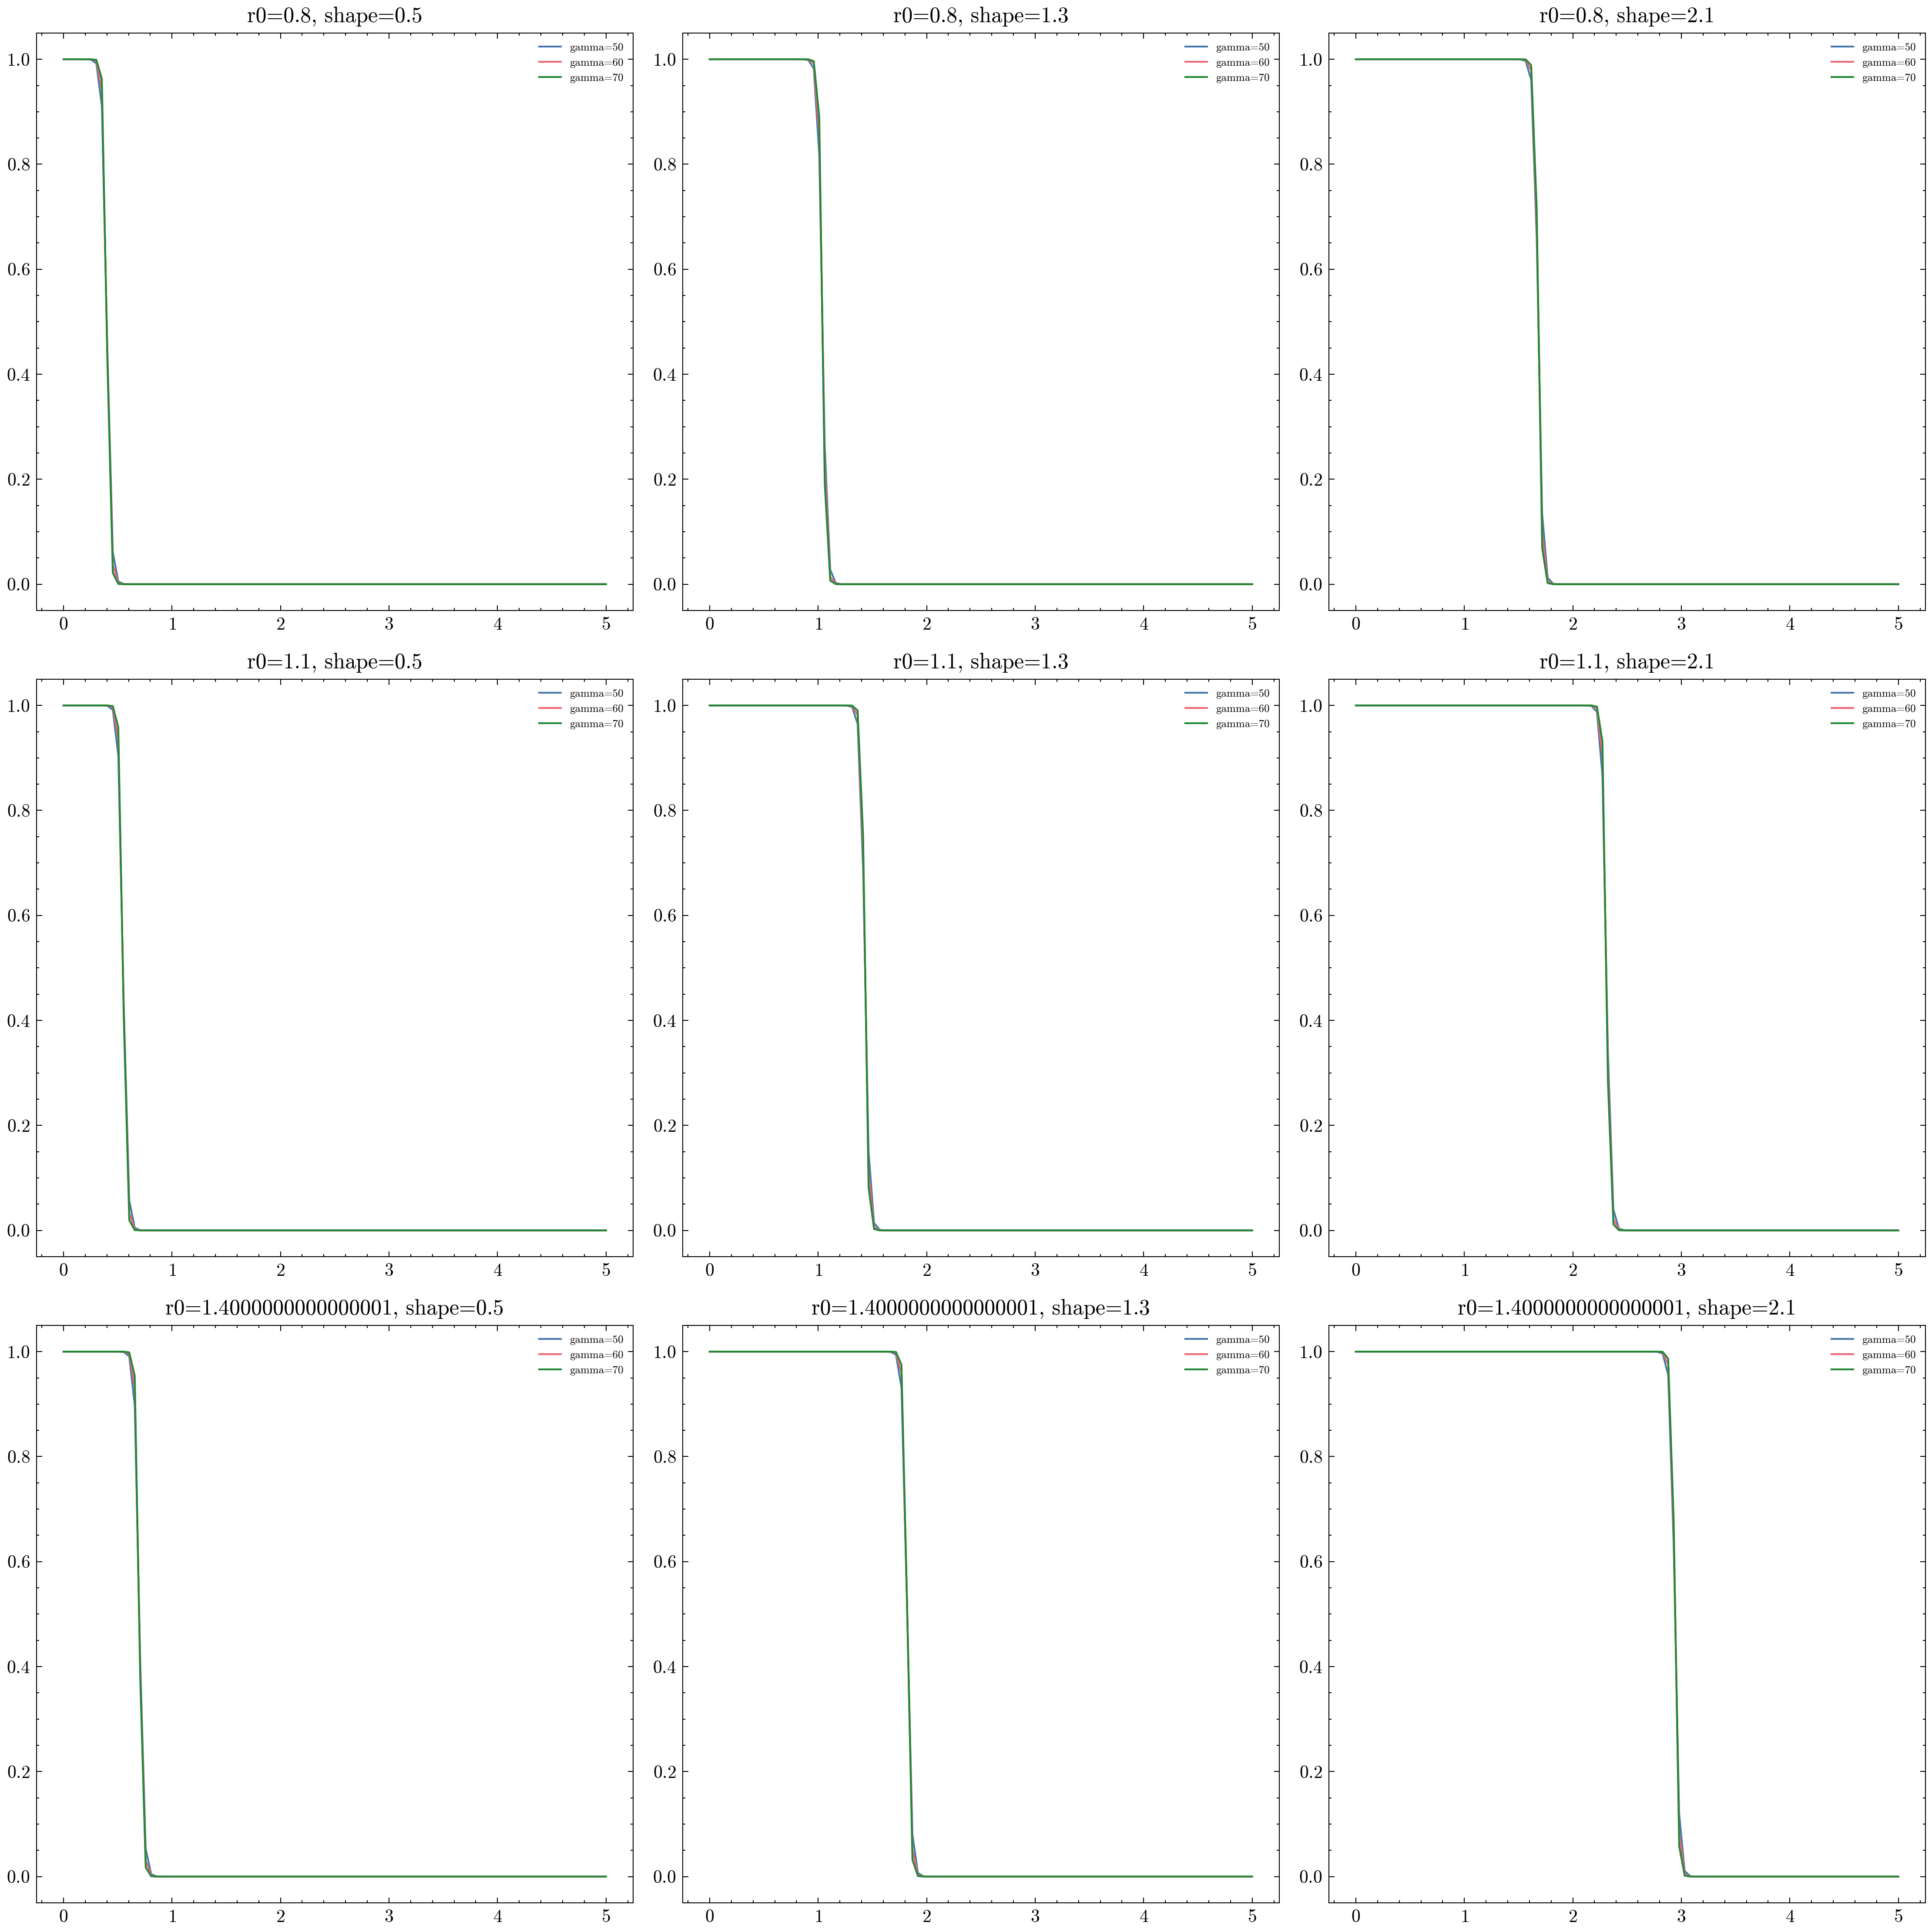

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def op(new_pos, gamma, r0, shape):
    return np.sum(1 / (1 + np.exp((new_pos - r0*shape)*gamma))) / np.float64(new_pos.shape[0])

def v_gauss(new_pos, gamma, r0, shape):
    return np.exp(-gamma * (new_pos - r0*shape)**2

gamma_values = np.arange(50, 71, 10)
r0_values = np.arange(0.8, 1.5, 0.3)
shape_values = np.arange(0.5, 2.2, 0.8)

x_vals = np.linspace(0, 5, 100)

fig, axs = plt.subplots(len(r0_values), len(shape_values), figsize=(15, 15), dpi=300)

for i, r0 in enumerate(r0_values):
    for j, shape in enumerate(shape_values):
        for gamma in gamma_values:
            y_vals = [op(np.array([x_val]), gamma, r0, shape) for x_val in x_vals]
            axs[i, j].plot(x_vals, y_vals, label=f'gamma={gamma}')
        axs[i, j].legend(fontsize=6)
        axs[i, j].set_title(f'r0={r0}, shape={shape}')

plt.tight_layout()
plt.show()

The Gaussian biasing potential \( V \) in a metadynamics simulation is given by:

$$
V(x_1, y_1, z_1, x_2, y_2, z_2, r_0, \gamma, \lambda, h, \sigma, s_{\text{Prev}}) = h \cdot \exp\left(-\frac{(s_{\text{Prev}} - CV)^2}{2\sigma^2}\right)
$$

where \( CV \) is the collective variable defined as:

$$
CV(x_1, y_1, z_1, x_2, y_2, z_2, r_0, \gamma, \lambda) = \frac{1}{1 + \exp\left(\gamma \cdot (r_{\text{Bar}} - \lambda \cdot r_0)\right)}
$$

and \( r_{\text{Bar}} \) is the Euclidean distance between the two particles:

$$
r_{\text{Bar}}(x_1, y_1, z_1, x_2, y_2, z_2) = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}
$$

To apply a biasing force to the particles, we need to calculate the gradient of the potential \( V \) with respect to the coordinates of the particles. The gradient of \( V \) with respect to \( x_1 \) is:

$$
\frac{\partial V}{\partial x_1} = -\frac{\partial}{\partial x_1} \left[ h \cdot \exp\left(-\frac{(s_{\text{Prev}} - CV)^2}{2\sigma^2}\right) \right]
$$

This derivative can be expanded using the chain rule:

$$
\frac{\partial V}{\partial x_1} = -h \cdot \exp\left(-\frac{(s_{\text{Prev}} - CV)^2}{2\sigma^2}\right) \cdot \left(-\frac{2(s_{\text{Prev}} - CV)}{2\sigma^2}\right) \cdot \frac{\partial CV}{\partial x_1}
$$

The derivative of \( CV \) with respect to \( x_1 \) is:

$$
\frac{\partial CV}{\partial x_1} = \frac{\partial}{\partial x_1} \left[ \frac{1}{1 + \exp\left(\gamma \cdot (r_{\text{Bar}} - \lambda \cdot r_0)\right)} \right]
$$

This derivative can be simplified further using the chain rule and the derivative of the exponential function:

$$
\frac{\partial CV}{\partial x_1} = -\frac{\gamma \cdot \exp\left(\gamma \cdot (r_{\text{Bar}} - \lambda \cdot r_0)\right)}{\left(1 + \exp\left(\gamma \cdot (r_{\text{Bar}} - \lambda \cdot r_0)\right)\right)^2} \cdot \frac{\partial r_{\text{Bar}}}{\partial x_1}
$$

And the derivative of \( r_{\text{Bar}} \) with respect to \( x_1 \) is:

$$
\frac{\partial r_{\text{Bar}}}{\partial x_1} = \frac{x_1 - x_2}{r_{\text{Bar}}}
$$

Putting it all together, the gradient of the biasing potential \( V \) with respect to \( x_1 \) is:

$$
\frac{\partial V}{\partial x_1} = h \cdot \exp\left(-\frac{(s_{\text{Prev}} - CV)^2}{2\sigma^2}\right) \cdot \frac{(s_{\text{Prev}} - CV)}{\sigma^2} \cdot \frac{\gamma \cdot \exp\left(\gamma \cdot (r_{\text{Bar}} - \lambda \cdot r_0)\right)}{\left(1 + \exp\left(\gamma \cdot (r_{\text{Bar}} - \lambda \cdot r_0)\right)\right)^2} \cdot \frac{x_1 - x_2}{r_{\text{Bar}}}
$$

This is the force component in the \( x \)-direction that would be applied to particle 1 due to the biasing potential in the metadynamics simulation. The force components in the \( y \) and \( z \) directions can be calculated similarly by taking the partial derivatives with respect to \( y_1 \) and \( z_1 \), respectively.

where \( \nabla V \) is the gradient of the potential \( V \) with respect to the coordinates of the particles, and the negative sign arises because the force is in the direction of the steepest descent of the potential energy surface.

So, the force in each direction \( F_x, F_y, F_z \) can be calculated by the following components:

$$
F_x = -\frac{\partial V}{\partial x_1} \cdot \frac{x_1 - x_2}{r_{\text{Bar}}}
$$

$$
F_y = -\frac{\partial V}{\partial y_1} \cdot \frac{y_1 - y_2}{r_{\text{Bar}}}
$$

$$
F_z = -\frac{\partial V}{\partial z_1} \cdot \frac{z_1 - z_2}{r_{\text{Bar}}}
$$